In [1]:
! pip install datasets

In [2]:
import numpy as np

In [3]:
from datasets import load_dataset
dataset = load_dataset("PedroSampaio/fruits-360")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 67690
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 22688
    })
})

In [5]:
train = dataset["train"]
test = dataset["test"]

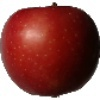

In [6]:
train[9]["image"]


In [7]:
train[5]["label"]

0

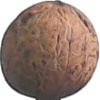

In [8]:
train[66557]["image"]

In [9]:
train[66557]["label"]

111

#exporter notre dataset sur huggingface

In [10]:
# from huggingface_hub import notebook_login

In [11]:
# notebook_login()

In [12]:

# dataset.push_to_hub("fruits")

#Encodage


In [13]:
label_names = dataset["train"].features["label"].names

print(label_names)

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red', 'Apple Red Delicious', 'Apple Red Yellow', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe', 'Carambula', 'Cauliflower', 'Cherry', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Nectarine Flat', 'Nut Forest', 'Nut Pecan', 'Onion Red', 'Onion Red Peeled', 'Onion White', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Peach Flat', '

In [14]:
label_to_id, id_to_label = dict(), dict()
for index, label in enumerate(label_names):
  label_to_id[label] = str(index)
  id_to_label[str(index)] = str(label)

In [15]:
label_to_id["Watermelon"]

'112'

In [16]:
id_to_label["112"]

'Watermelon'

In [17]:
len(label_to_id)

113

#Preprocessing

In [18]:
from transformers import AutoImageProcessor

In [19]:
#https://huggingface.co/microsoft/resnet-50/blob/main/README.md
model_name = "microsoft/resnet-50"
image_processor = AutoImageProcessor.from_pretrained(model_name)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [20]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
normalize = Normalize(image_processor.image_mean, std = image_processor.image_std)
size = (image_processor.size["shortest_edge"] if "shortest_edge" in image_processor.size else (image_processor.size["height"]))
_transform = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [21]:
def transform(examples):

    if "image" in examples:
        examples["pixel_values"] = [_transform(img.convert("RGB")) for img in examples["image"]]
        del examples["image"]

    return examples


In [22]:
dataset = dataset.with_transform(transform)

In [23]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 67690
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 22688
    })
})

In [24]:
from transformers import DefaultDataCollator
data_collector = DefaultDataCollator() #permet de transformer les données en batch

In [25]:
! pip install evaluate

In [26]:
import evaluate
accuracy = evaluate.load("accuracy")

In [27]:
def compute_metrics(eval_pred):
  prediction, label = eval_pred
  prediction = np.argmax(prediction, axis = 1)
  return accuracy.compute(predictions = prediction, references = label)

In [28]:
# def encode_labels(batch):
#   batch["label"] = [label_to_id[label] for label in batch["label"]]

#   return batch

In [29]:
# dataset = dataset.map(encode_labels, batched=True)

In [30]:
len(label_to_id)

113

In [31]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
model =  AutoModelForImageClassification.from_pretrained(model_name, num_labels = len(label_to_id), id2label = id_to_label, label2id = label_to_id,ignore_mismatched_sizes=True )

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([113]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([113, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
training_argument = TrainingArguments(
    output_dir="classification_de_fruits",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 10,
    #push_to_hub = True,
    metric_for_best_model = "accuracy",
    load_best_model_at_end = True,
    learning_rate = 5e-5,
    remove_unused_columns= False
    )
trainer = Trainer(model = model,
                  compute_metrics = compute_metrics,
                  tokenizer = image_processor,
                  args = training_argument,
                  train_dataset = dataset["train"],
                  eval_dataset = dataset["test"]
                  )

<ipython-input-32-b6476ca5dfa2>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model = model,


In [33]:
 trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: roy61 (roy61-dit) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.458700,0.276610,0.924894
2,0.173600,0.107033,0.966987
3,0.104200,0.097871,0.970028
4,0.086200,0.084098,0.975978
5,0.070000,0.063901,0.981620
6,0.061000,0.060856,0.982590
7,0.056500,0.049633,0.985323
8,0.043000,0.054197,0.984926
9,0.041500,0.043434,0.987262
10,0.045500,0.039289,0.987835


TrainOutput(global_step=42310, training_loss=0.24587219748139746, metrics={'train_runtime': 9699.4643, 'train_samples_per_second': 69.787, 'train_steps_per_second': 4.362, 'total_flos': 1.4513290418053325e+19, 'train_loss': 0.24587219748139746, 'epoch': 10.0})

#Évaluation du modèle

In [ ]:

resultats = trainer.evaluate()
print("Résultats de l'évaluation :", resultats)


In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report



# Fonction pour récupérer les prédictions
def predictions(trainer, dataset):
    preds = trainer.predict(dataset)
    y_pred = np.argmax(preds.predictions, axis=1)  # Classes prédites
    y_true = dataset["label"]
    return y_true, y_pred

# Obtenir y_true et y_pred sur les données de test
y_true, y_pred = predictions(trainer, dataset["test"])

# Afficher le rapport de classification
print("Rapport de classification :\n", classification_report(y_true, y_pred))

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred)

# Afficher la matrice de confusion avec Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(id_to_label.values()), yticklabels=list(id_to_label.values()))
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("Matrice de Confusion - Fruits Classification")
plt.show()

# Vérification rapide du contenu d'un exemple
print(dataset["test"].column_names)
print(dataset["test"][0])


In [42]:
print(dataset["test"].column_names)
print(dataset["test"][0])

['image', 'label']
{'label': 0, 'pixel_values': tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [2.2318, 2.2318, 2.2318,  ..., 2.2318, 2.2318, 2.2318],
         [2.2489, 2.2489, 2.2318,  ..., 2.2318, 2.2318, 2.2318],
         [2.2489, 2.2489, 2.2318,  ..., 2.2318, 2.2318, 2.2318]],

        [[2.4286, 2.4286, 2.4286,  ..., 2.4111, 2.3936, 2.3936],
         [2.4286, 2.4286, 2.4286,  ..., 2.4111, 2.3936, 2.3936],
         [2.4286, 2.4286, 2.4286,  ..., 2.4111, 2.3936, 2.3936],
         ...,
         [2.4286, 2.4286, 2.4286,  ..., 2.4111, 2.4111, 2.4111],
         [2.4286, 2.4286, 2.4286,  ..., 2.4111, 2.4111, 2.4111],
         [2.4286, 2.4286, 2.4286,  ..., 2.4111, 2.4111, 2.4111]],

        [[2.6400, 2.6400, 2.6400,  ..., 2.6226, 2.6226, 2.6226],
         [2.6400, 2.6400, 2.6400,  ..., 2.6226, 2.6226, 2.6226],
         [

#Test sur de nouvelles images

In [ ]:
from PIL import Image
import torch
import matplotlib.pyplot as plt

def predict_image(image_path, model, processor, id_to_label):
    # Ouvrir l'image
    image = Image.open(image_path).convert("RGB")

    # Prétraitement de l'image
    inputs = processor(image, return_tensors="pt")

    # Prédiction avec le modèle
    model.eval()  # Mode évaluation
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = logits.argmax(-1).item()  # Récupère la classe prédite

    # Convertir l'ID de la classe en nom de classe
    label_pred = id_to_label[str(predicted_class)]
    print(f"Prédiction : {label_pred}")
    return label_pred, image

# Chemin de l'image externe
image_path = "pomme-rouge.jpg"

# Faire la prédiction
predicted_label, image = predict_image(image_path, model, image_processor, id_to_label)

# Afficher l'image avec la prédiction
plt.imshow(image)
plt.title(f"Prédiction : {predicted_label}")
plt.axis('off')
plt.show()

#Sauvegarde du modele pour l'api flask

In [40]:
# Sauvegarde dy modele
model.save_pretrained("mymodel")
image_processor.save_pretrained("mymodel")

import json

# Sauvegarde des labels
chemin = "mymodel/id_to_label.json"

with open(chemin, "w") as f:
    json.dump(id_to_label, f)

